<a href="https://colab.research.google.com/gist/Simran-Sh/7c012de642235a49b143b1716cd1eac9/creditcard_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LOAD LIBRARIES

In [36]:
# If running in Colab or a clean env, run these once:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


# LOAD DATASET


In [3]:
df = pd.read_csv('/content/creditcard.csv')

# CHECK SIZE OF DATASET

In [6]:
df.shape

(120901, 31)

PRINT 1ST 5 RECORDS

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


CHECK IF NULL EXIST!!

In [9]:
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [10]:
df['Class'].value_counts()

,count
Class,
0.0,120651
1.0,249


In [11]:
df['Class'].mean()

np.float64(0.0020595533498759307)

# CHECK FOR RECORDS WITH MISSING VALUES

In [12]:
missing_rows = df[df.isnull().any(axis=1)]
print("Rows with missing values:", missing_rows.shape[0])
display(missing_rows)

Rows with missing values: 1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
120900,76001,-0.367988,1.108999,0.787889,1.043825,-0.336914,-0.554318,0.307948,0.402319,-0.651386,...,0.226379,0.551456,0.058382,0.394346,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_clean = df.dropna().reset_index(drop=True)
df_clean.shape

(120900, 31)

In [18]:
df_clean.isnull().sum().sum()

np.int64(0)

In [19]:
df_clean['Class'].mean()

np.float64(0.0020595533498759307)

# PREPARE FEATURES AND TARGET







In [20]:
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

# TRAIN - TEST - SPLIT (stratified)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train fraud ratio:", y_train.mean(), "Test fraud ratio:", y_test.mean())

Train shape: (96720, 30) Test shape: (24180, 30)
Train fraud ratio: 0.002057485525227461 Test fraud ratio: 0.0020678246484698098


# SCALE AMOUNT AND TIME

In [23]:
# safe copies
X_train = X_train.copy()
X_test  = X_test.copy()
cols_to_scale = ['Amount', 'Time']

scaler = StandardScaler()
X_train.loc[:, cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test.loc[:, cols_to_scale] = scaler.transform(X_test[cols_to_scale])


In [24]:
# verify
display(X_train[cols_to_scale].describe().T)

,count,mean,std,min,25%,50%,75%,max
Amount,96720.0,-4.334369e-18,1.000005,-0.375956,-0.348108,-0.275785,-0.036446,78.384780
Time,96720.0,-2.865092e-18,1.000005,-2.496364,-0.610097,0.095565,0.819466,1.495179


# BASELINE 1:  Logistic Regression



In [26]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression - classification report:\n")
print(classification_report(y_test, y_pred_lr, digits=4))


Logistic Regression - classification report:

              precision    recall  f1-score   support

         0.0     0.9998    0.9766    0.9881     24130
         1.0     0.0754    0.9200    0.1394        50

    accuracy                         0.9765     24180
   macro avg     0.5376    0.9483    0.5637     24180
weighted avg     0.9979    0.9765    0.9863     24180



In [27]:
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print("Average precision (AP):", average_precision_score(y_test, y_proba_lr))

ROC AUC: 0.9796411106506423
Average precision (AP): 0.6616540659198332


# BASELINE 2: RANDOM FOREST

In [29]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest - classification report:\n")
print(classification_report(y_test, y_pred_rf, digits=4))

Random Forest - classification report:

              precision    recall  f1-score   support

         0.0     0.9996    1.0000    0.9998     24130
         1.0     0.9762    0.8200    0.8913        50

    accuracy                         0.9996     24180
   macro avg     0.9879    0.9100    0.9455     24180
weighted avg     0.9996    0.9996    0.9996     24180



In [30]:
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Average precision (AP):", average_precision_score(y_test, y_proba_rf))

ROC AUC: 0.9691922917530046
Average precision (AP): 0.9095988271636826


# RF with SMOTE (IMBPIPELINE)

In [34]:
pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

pipeline.fit(X_train, y_train)
y_pred_smote = pipeline.predict(X_test)
y_proba_smote = pipeline.predict_proba(X_test)[:, 1]

print("Random Forest + SMOTE - classification report:\n")
print(classification_report(y_test, y_pred_smote, digits=4))



Random Forest + SMOTE - classification report:

              precision    recall  f1-score   support

         0.0     0.9997    0.9999    0.9998     24130
         1.0     0.9348    0.8600    0.8958        50

    accuracy                         0.9996     24180
   macro avg     0.9672    0.9299    0.9478     24180
weighted avg     0.9996    0.9996    0.9996     24180



In [ ]:
print("ROC AUC:", roc_auc_score(y_test, y_proba_smote))
print("Average precision (AP):", average_precision_score(y_test, y_proba_smote))

# COMPARE MODELS VISUALLY



ROC and Precision-Recall

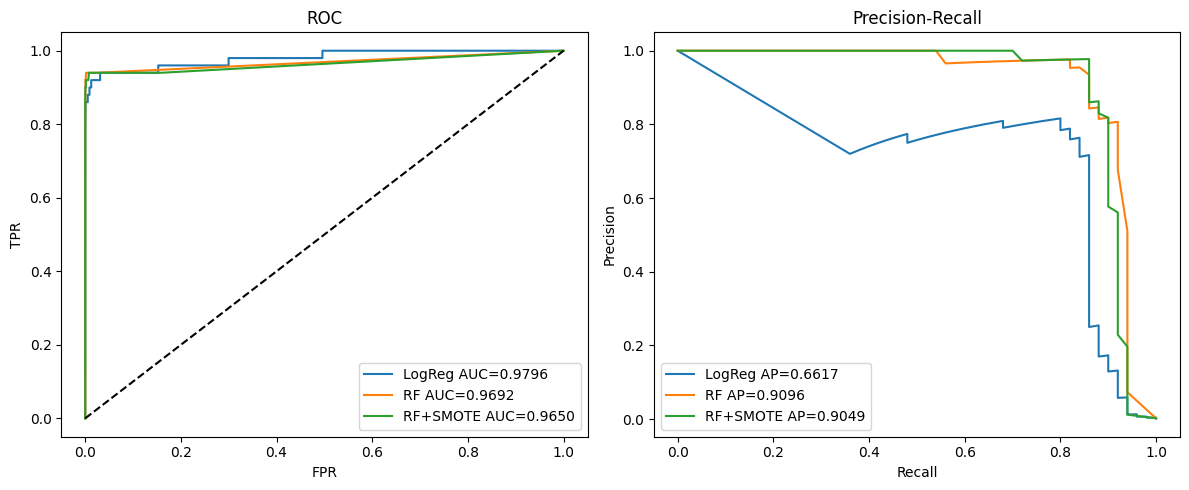

In [35]:
plt.figure(figsize=(12,5))

# ROC
plt.subplot(1,2,1)
fpr, tpr, _ = roc_curve(y_test, y_proba_lr); plt.plot(fpr, tpr, label=f"LogReg AUC={roc_auc_score(y_test,y_proba_lr):.4f}")
fpr, tpr, _ = roc_curve(y_test, y_proba_rf); plt.plot(fpr, tpr, label=f"RF AUC={roc_auc_score(y_test,y_proba_rf):.4f}")
fpr, tpr, _ = roc_curve(y_test, y_proba_smote); plt.plot(fpr, tpr, label=f"RF+SMOTE AUC={roc_auc_score(y_test,y_proba_smote):.4f}")
plt.plot([0,1],[0,1],'k--'); plt.title("ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

# Precision-Recall
plt.subplot(1,2,2)
prec, rec, _ = precision_recall_curve(y_test, y_proba_lr); plt.plot(rec, prec, label=f"LogReg AP={average_precision_score(y_test,y_proba_lr):.4f}")
prec, rec, _ = precision_recall_curve(y_test, y_proba_rf); plt.plot(rec, prec, label=f"RF AP={average_precision_score(y_test,y_proba_rf):.4f}")
prec, rec, _ = precision_recall_curve(y_test, y_proba_smote); plt.plot(rec, prec, label=f"RF+SMOTE AP={average_precision_score(y_test,y_proba_smote):.4f}")
plt.title("Precision-Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()

plt.tight_layout(); plt.show()


Threshold tuning: pick threshold to trade precision vs recall


Threshold = 0.5
              precision    recall  f1-score   support

         0.0     0.9997    0.9998    0.9998     24130
         1.0     0.9149    0.8600    0.8866        50

    accuracy                         0.9995     24180
   macro avg     0.9573    0.9299    0.9432     24180
weighted avg     0.9995    0.9995    0.9995     24180



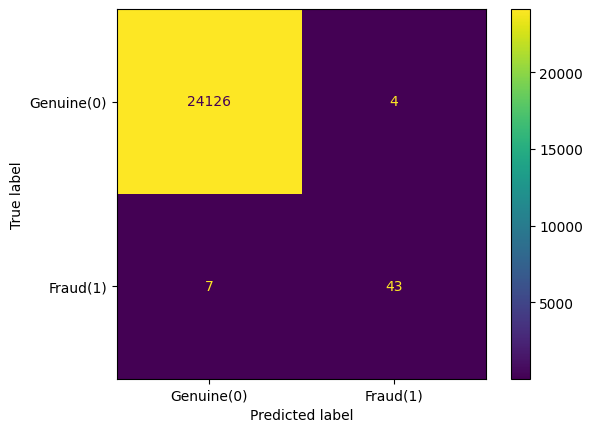


Threshold = 0.3
              precision    recall  f1-score   support

         0.0     0.9998    0.9994    0.9996     24130
         1.0     0.7500    0.9000    0.8182        50

    accuracy                         0.9992     24180
   macro avg     0.8749    0.9497    0.9089     24180
weighted avg     0.9993    0.9992    0.9992     24180



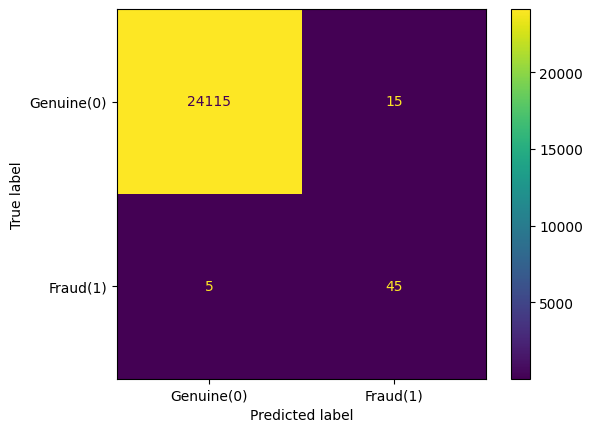


Threshold = 0.2
              precision    recall  f1-score   support

         0.0     0.9998    0.9990    0.9994     24130
         1.0     0.6429    0.9000    0.7500        50

    accuracy                         0.9988     24180
   macro avg     0.8213    0.9495    0.8747     24180
weighted avg     0.9991    0.9988    0.9989     24180



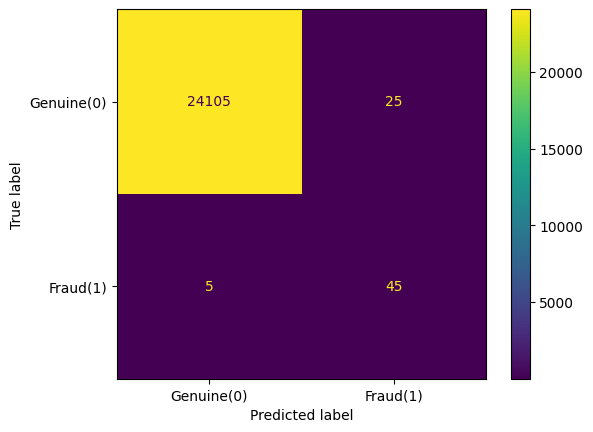


Threshold = 0.1
              precision    recall  f1-score   support

         0.0     0.9998    0.9970    0.9984     24130
         1.0     0.3866    0.9200    0.5444        50

    accuracy                         0.9968     24180
   macro avg     0.6932    0.9585    0.7714     24180
weighted avg     0.9986    0.9968    0.9975     24180



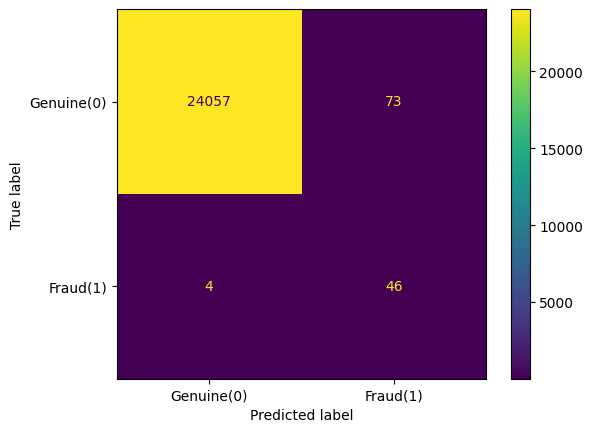

In [41]:
probs = y_proba_smote  # use the pipeline's probabilities (or choose whichever model)
thresholds = [0.5, 0.3, 0.2, 0.1]

for thr in thresholds:
    preds_thr = (probs >= thr).astype(int)
    print(f"\nThreshold = {thr}")
    print(classification_report(y_test, preds_thr, digits=4))
    cm = confusion_matrix(y_test, preds_thr)
    ConfusionMatrixDisplay(cm, display_labels=["Genuine(0)","Fraud(1)"]).plot()
    plt.show()

 Threshold by expected cost

Best threshold by expected cost: 0.14
Expected cost at that threshold: 2380


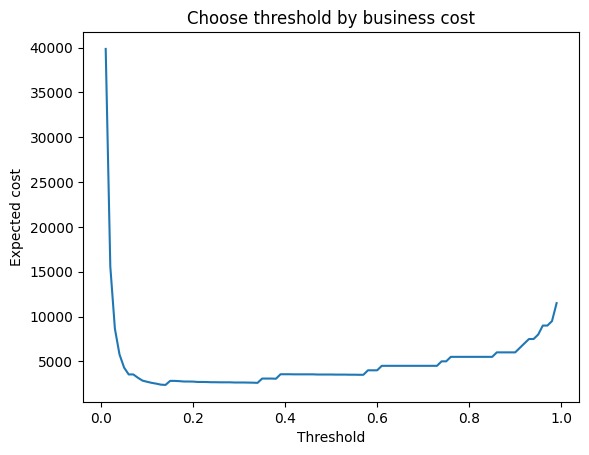

In [46]:

cost_FP = 10   # cost for investigating a false alarm (in currency units)
cost_FN = 500  # cost of a missed fraud (average loss)

thresholds = np.linspace(0.01, 0.99, 99)
costs = []
for thr in thresholds:
    preds = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    total_cost = fp * cost_FP + fn * cost_FN
    costs.append(total_cost)

best_idx = np.argmin(costs)
print("Best threshold by expected cost:", thresholds[best_idx])
print("Expected cost at that threshold:", costs[best_idx])
# optional: plot
import matplotlib.pyplot as plt
plt.plot(thresholds, costs)
plt.xlabel("Threshold"); plt.ylabel("Expected cost"); plt.title("Choose threshold by business cost"); plt.show()


# Hyperparameter tuning

number of hyperparameters tested

In [54]:
param_grid = {
    'clf__n_estimators': [100],
    'clf__max_depth': [None, 15],
    'clf__min_samples_split': [2]
}

Cross-validation folds

In [55]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)


In [56]:
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [57]:
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [60]:
grid.best_params_


{'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

In [61]:
best_model = grid.best_estimator_

# PREDICTIONS AND PROBABILITIES

In [62]:
y_pred_gs = best_model.predict(X_test)
y_proba_gs = best_model.predict_proba(X_test)[:, 1]


# EVALUATE MODEL ON TEST DATASET


Test set gives the real unbiased performance.

In [63]:
print(classification_report(y_test, y_pred_gs, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_gs))

              precision    recall  f1-score   support

         0.0     0.9997    0.9999    0.9998     24130
         1.0     0.9348    0.8600    0.8958        50

    accuracy                         0.9996     24180
   macro avg     0.9672    0.9299    0.9478     24180
weighted avg     0.9996    0.9996    0.9996     24180

ROC AUC: 0.9650397845006216


In [64]:
print("Average precision (AP):", average_precision_score(y_test, y_proba_gs))

Average precision (AP): 0.9049318404610671


# SAVE THE TRAINED MODEL

In [67]:
import joblib
joblib.dump(best_model, "credit_fraud_model.joblib")


['credit_fraud_model.joblib']

In [69]:
model = joblib.load("credit_fraud_model.joblib")
model.predict(X_test)


array([0., 0., 0., ..., 0., 0., 0.])

Check model is ok?

In [72]:
pd.Series(y_pred_gs).value_counts()


,count
0.0,24134
1.0,46


Show the top transactions by predicted fraud probability

In [73]:
top_idx = np.argsort(probs)[-10:][::-1]
pd.DataFrame({
    'prob': probs[top_idx],
    'true_class': y_test.values[top_idx]
}, index=top_idx)

,prob,true_class
21095,1.0,1.0
3036,1.0,1.0
2257,1.0,1.0
9696,1.0,1.0
9112,1.0,1.0
8879,1.0,1.0
16523,1.0,1.0
7315,1.0,1.0
19417,1.0,1.0
16131,1.0,1.0


# CONFUSION MATRIX (@ default threshold 0.5)

In [75]:
preds_default = (probs >= 0.5).astype(int)
print(classification_report(y_test, preds_default, digits=4))


              precision    recall  f1-score   support

         0.0     0.9997    0.9998    0.9998     24130
         1.0     0.9149    0.8600    0.8866        50

    accuracy                         0.9995     24180
   macro avg     0.9573    0.9299    0.9432     24180
weighted avg     0.9995    0.9995    0.9995     24180



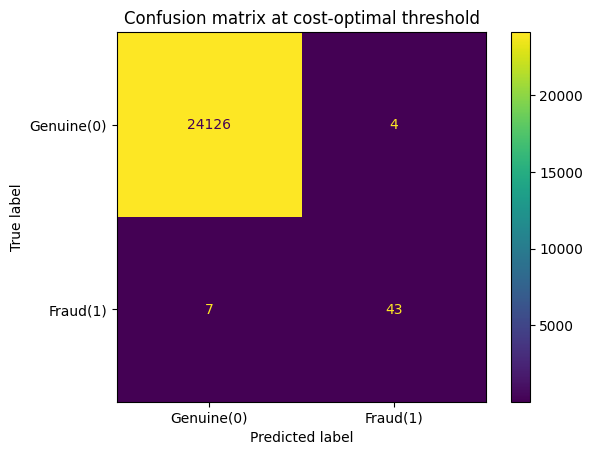

In [80]:
cm = confusion_matrix(y_test, preds_default)
ConfusionMatrixDisplay(cm, display_labels=['Genuine(0)','Fraud(1)']).plot()
plt.title("Confusion matrix at cost-optimal threshold")
plt.show()